In [1]:
import matplotlib.pyplot as plt
from itertools import combinations, product

import numpy as np

from neurodsp.sim import sim_action_potential
    
from bycycle.spikes.cyclepoints import compute_spike_cyclepoints
from bycycle.spikes.utils import split_signal

from sklearn.cluster import KMeans

## Spike Clustering

This notebook was motivated by recent findings that template-based spike sorting is more accurate than clustering methods$^{1}$. In response to this these findings, I wanted to see if sorted spike clusters could be demixed into their component sources. First, two spikes with different shapes are simulated. Three signals are then simulated with these spikes via convolution with a Possion. The Posisson is shift to varying degrees for each signal to produce two additional spikes that are uniquely shaped as a linear combination of the two spike sources. An algorithm is then used to sucessfully demix the linearly combined spikes.

[1] How do spike collisions affect spike sorting performance? Samuel Garcia, Alessio P. Buccino, Pierre Yger bioRxiv 2021.11.29.470450; doi: https://doi.org/10.1101/2021.11.29.470450 

### 1. Spike Sources

Below, two differently shape spikes are simulate that will be used together to generate two additional spikes.

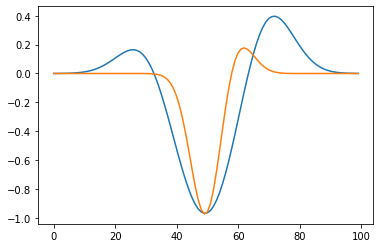

In [2]:
n_seconds = 1
fs = 100

centers = [[.3, .5, .7], [.5, .6]]
stds = [[.08, .1, .08], [.05, .05]]
alphas = [[0, 0, 0], [0, 0]]
heights = [[.25, -1, .5], [-1, .25]]


ap_0 = sim_action_potential(n_seconds, fs, centers[0], stds[0], alphas[0], heights[0])
ap_1 = sim_action_potential(n_seconds, fs, centers[1], stds[1], alphas[1], heights[1])


plt.plot(ap_0)
plt.plot(ap_1)

### 2. Spike Mixing
Next, the above two spikes are mixed to various degrees in time. The top plot represents the two spikes independenly in time, whereas the bottom plot represents a full mix of the two spikes.

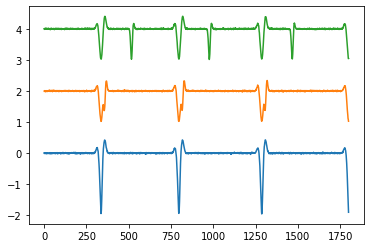

In [3]:
n_seconds = 18
fs = 10000
n_samples = int(n_seconds * fs)

shift_len = 400
shifts = ((np.logspace(0, 1, 3) -1 ) * 20).astype(int)
shifts = np.array([ 0, 20, 180])

inds = np.cumsum(np.random.poisson(lam=500, size=int(n_samples / 200)))
inds = inds[np.where(inds <= n_samples+shift_len)[0]]

pad_len = int(2 * fs)
sigs = np.zeros((len(shifts), n_samples + pad_len))

for ind, shift in enumerate(shifts):
    
    sig_a = np.zeros(int(n_samples + pad_len))
    sig_a[inds] = 1
    sig_a = np.convolve(sig_a, ap_0, mode='same')
    
    sig_b = np.zeros(int(n_samples + pad_len))
    sig_b[inds+shift] = 1
    sig_b = np.convolve(sig_b, ap_1, mode='same')
    
    noise = np.random.normal(0, .01, len(sig_a))
    sigs[ind] = sig_a + sig_b + noise
    sigs[ind]
    
i=0
for _sig in sigs:
    plt.plot(_sig[200:2000]+i)
    i+=2

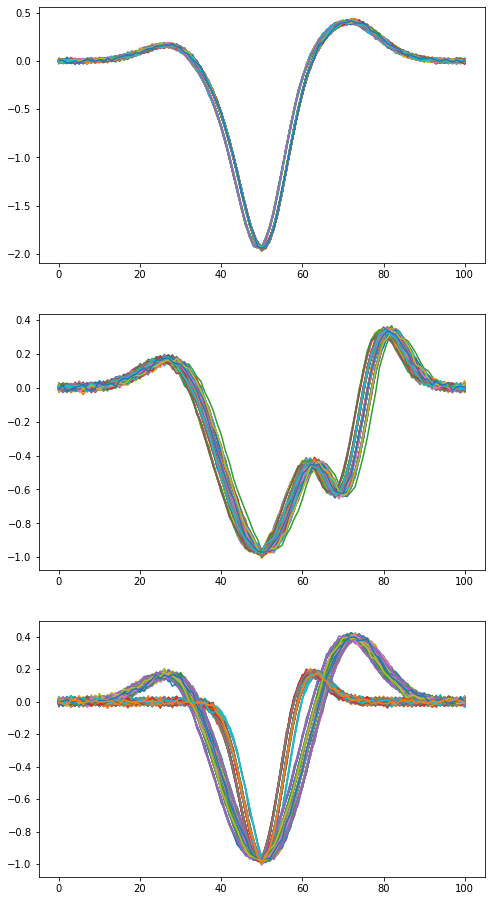

In [4]:
# Isolate spikes from signal
std = 2
f_range = (80, 120)

spikes = []

for sig in sigs:
    df_cps = compute_spike_cyclepoints(sig, fs, f_range, std)
    
    df_cps['sample_start'] = df_cps['sample_trough'] - 50
    df_cps['sample_end'] = df_cps['sample_trough'] + 50
    spikes.append(split_signal(df_cps, sig))

# Plot
fig, axes = plt.subplots(nrows=3, figsize=(8, 16))

for i in spikes[0]:
    axes[0].plot(i)
    
for i in spikes[1]:
    axes[1].plot(i)
    
for i in spikes[2]:
    axes[2].plot(i)

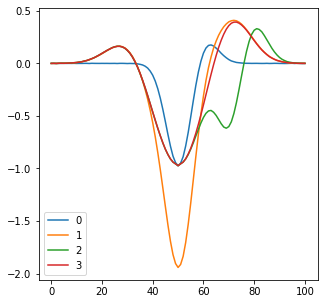

In [6]:
# Separate the two spike shape when they occur independently
km_0 = KMeans(n_clusters=2)
inds = km_0.fit_predict(spikes[2])

spikes_split = np.zeros((spikes[0].shape[0] *4, spikes[0].shape[1]))

i = 0
for sps in spikes:
    for sp in sps:
        spikes_split[i] = sp
        i += 1
        
# Cluster mean of unique spikes
km = KMeans(n_clusters=4)
inds = km.fit_predict(spikes_split)

spikes_mean = np.zeros((4, len(spikes_split[0])))

for ind in np.unique(inds):
    spikes_mean[ind] = spikes_split[np.where(inds == ind)[0]].mean(axis=0)
    
# Plot    
plt.figure(figsize=(5, 5))
colors = ['C0', 'C1', 'C2', 'C3']

for ind, sp in enumerate(spikes_mean):
    plt.plot(sp, color=colors[ind], label=str(ind))
    
plt.legend()

### 3. Spike Source Separation

In [7]:
def demix_spikes(spikes, mode='linear', n_sources=2, width_range=20, metric='mae'):
    """Spike source seperation."""
    
    source_inds = np.array(list(combinations(np.arange(len(spikes)), n_sources)))
    
    width_range = len(spikes[0])-1 if width_range >= len(spikes[0]) else width_range
    widths = np.array(list(product(np.arange(-width_range, width_range+1),
                                   repeat=n_sources)))
    
    metrics = np.zeros((len(source_inds), len(widths)))
    for sind, src in enumerate(source_inds):
        
        sources = spikes[src]
        targets = np.delete(spikes_mean, [0, 1], axis=0)
        
        for wind, width in enumerate(widths):
            
            _metric = np.zeros(len(targets))
            for tind, target in enumerate(targets):
                
                spikes_shift = np.array([np.roll(s, w) for s, w in zip(sources, width)])
                spikes_shift = spikes_shift.sum(axis=0)
            
                if metric == 'mae':
                    _metric[tind] = np.mean(np.abs(target - spikes_shift))
            
            metrics[sind, wind] = _metric.mean()
        
    loc = np.where(metrics == np.min(metrics))
    
    sources = spikes[source_inds[loc[0][0]]]
    
    return sources, metrics

In [8]:
sources, metrics = demix_spikes(spikes_mean, mode='linear', n_sources=2)

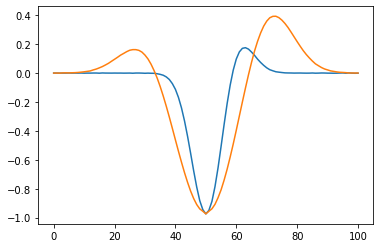

In [9]:
# Demixed spikes
for s in sources:
    plt.plot(s)

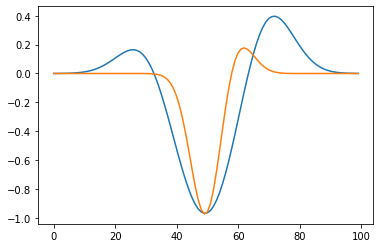

In [10]:
# Original sources
plt.plot(ap_0)
plt.plot(ap_1)